# Yoga (Project): Autoclarity


> Objectives:
>
> - Practice implementing deep neural networks
>   - Experiment with layer and bottleneck sizes in autoencoders
>   - Experiment with different layer types (convolutional, pooling, dropout, etc.)

<small>🤖 AI code generation IS recommended for this notebook.</small>

<small>🙋 Have a suggestion for how to improve this file? Please open an issue for [this repo on GitHub](https://github.com/orgs/deepatlasai/repositories). Create a Help Desk ticket in Discord for time-sensitive technical issues.</small>


## Standard Deep Atlas Exercise Set Up

- [ ] Ensure you are using the coursework Pipenv environment and kernel ([instructions](../SETUP.md))
- [ ] Apply the standard Deep Atlas environment setup process by running this cell:

In [8]:
import sys, os
sys.path.insert(0, os.path.join('..', 'includes'))
import deep_atlas

In [11]:
from torchinfo import summary
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms




In [13]:
# # Figure out wandb
# import wandb
# # os.environ["WANDB_NOTEBOOK_NAME"] = "autoclarity.ipynb"
# wandb.login(key="869ae4e1f889a46f3fa01fd139f167a9f5a9a487")

# wandb.init(project="autoclarity", 
#            name="autoclarity",
#            entity="kevincorstorphine")

In [14]:
# Device to translate tensors to:
device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

# Configuration:
batch_size = 64
num_epochs = 10
learning_rate = 0.001

# wandb.config.batch_size = batch_size


### 🚦 Checkpoint: Start

- [ ] Run this cell to record your start time:

In [2]:
deep_atlas.log_start_time()

Started at: 2025-05-08T16:27:09.849824
🚀 Success! Get started...


## Image De-noising with Autoencoders


Adapt your deep learning knowledge to work on a model that can clean up noisy images.

Autoencoders are class of deep neural networks that are constructed to be symmetrical: input values undergo dimensionality reduction in the first half of the network (encoder), and the lower-dimensional embeddings undergo reconstruction in the second half (decoder).

![Autoencoder diagram illustrating many input nodes passing information to a smaller number of hidden nodes in the middle, which in turn pass information to output nodes (the same amount as the inputs)](./assets/Ae%202133x1600.png)

As such, autoencoders are capable of reconstructing data that is informed by or very closely matches the input.

By adjusting the loss calculation, the decoder can be trained to adjust the outputs to achieve a desired affect.

For example: By training an autoencoder on noisy images but rewarding it for producing denoised images, we can train an image denoiser!

![Examples of images (originals, noisy, and denoised)](./assets/output.png)

This is extremely useful for digital cameras, which produce noise when trying to compensate for low light, but can be generalized to any image and dataset cleaning / smoothing tasks like increasing contrast in medical images or performing anomaly detection. 


## Project Goals


Implement an autoencoder that cleans MNIST images

- [ ] Design a model that accepts 784-dimensional vectors and reduces them to some small number of dimensions
  - Tip: start with simple model (e.g. stacking linear layers) before exploring more capable architectures.
- [ ] Add more layers which increases the dimensions back to the input size.
- [ ] Set up a training loop which feeds in noisy versions of the MNIST inputs but is rewarded for reconstructing clean versions.

> Hint: This function will add noise to images (you may need to tweak it if your images are not grayscale bitmaps).
>
> ```py
> # Adding noise to the dataset
> def add_noise(img):
>     noise = torch.randn(img.size()).to(device) * 0.2
>     noisy_img = img + noise
>     return noisy_img
> ```

- [ ] Experiment with the following:
  - Layer and bottleneck sizes
  - Types of layers (convolutional, pooling, dropout, etc.)
  - Training hyperparameters (epochs, batch size, etc.)


In [15]:
# Load data

# Transforms
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Datasets
train_dataset = torchvision.datasets.MNIST(
    root="./downloads", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./downloads", train=False, transform=transform, download=True
)

# Data-loader
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 7774917.65it/s] 


Extracting ./downloads/MNIST/raw/train-images-idx3-ubyte.gz to ./downloads/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 366407.22it/s]


Extracting ./downloads/MNIST/raw/train-labels-idx1-ubyte.gz to ./downloads/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 3654134.34it/s]


Extracting ./downloads/MNIST/raw/t10k-images-idx3-ubyte.gz to ./downloads/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2466087.87it/s]

Extracting ./downloads/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./downloads/MNIST/raw



In [16]:
# Adding noise to the dataset
def add_noise(img, noise_factor=0.2):
    noise = torch.randn(img.size()).to(device) * noise_factor
    noisy_img = img + noise
    return noisy_img

In [17]:
# Linear-Linear-Tanh Autoencoder
class Autoencoder_FC(nn.Module):
    def __init__(self):
        super(Autoencoder_FC, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),  # Compressed representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



mlp_model = Autoencoder_FC().to(device)

In [18]:
# Use torchinfo summary to get model summary
summary(mlp_model, input_size=(batch_size, 28 * 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder_FC                           [64, 784]                 --
├─Sequential: 1-1                        [64, 12]                  --
│    └─Linear: 2-1                       [64, 128]                 100,480
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 64]                  8,256
│    └─ReLU: 2-4                         [64, 64]                  --
│    └─Linear: 2-5                       [64, 12]                  780
├─Sequential: 1-2                        [64, 784]                 --
│    └─Linear: 2-6                       [64, 64]                  832
│    └─ReLU: 2-7                         [64, 64]                  --
│    └─Linear: 2-8                       [64, 128]                 8,320
│    └─ReLU: 2-9                         [64, 128]                 --
│    └─Linear: 2-10                      [64, 784]                 101,1

In [19]:
models = {
    "mlp_model": mlp_model, 
    "mlp_model_optimizer": torch.optim.Adam(
        mlp_model.parameters(), lr=learning_rate
    ),}

In [20]:
criterion = nn.SmoothL1Loss()

Epoch [1/10], Loss: 0.0324
mlp_model Validation Loss: 0.0399
Epoch [2/10], Loss: 0.0399
mlp_model Validation Loss: 0.0373
Epoch [3/10], Loss: 0.0348
mlp_model Validation Loss: 0.0359
Epoch [4/10], Loss: 0.0327
mlp_model Validation Loss: 0.0346
Epoch [5/10], Loss: 0.0303
mlp_model Validation Loss: 0.0335
Epoch [6/10], Loss: 0.0328
mlp_model Validation Loss: 0.0326
Epoch [7/10], Loss: 0.0279
mlp_model Validation Loss: 0.0321
Epoch [8/10], Loss: 0.0294
mlp_model Validation Loss: 0.0313
Epoch [9/10], Loss: 0.0231
mlp_model Validation Loss: 0.0308
Epoch [10/10], Loss: 0.0361
mlp_model Validation Loss: 0.0304


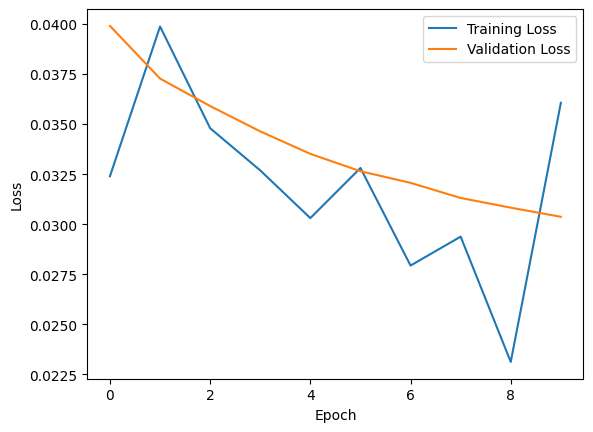

KeyError: 'cnn_model'

In [ ]:
model_names = ["mlp_model"]

for model_name in model_names:

    model = models[model_name]
    optimizer = models[f"{model_name}_optimizer"]

    epoch_losses = []
    validation_losses = []

    # if model_name == "mlp_model":
        # wandb.watch(model, log_freq=100)

    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)

            # Forward pass
            outputs = model(noisy_img)
            loss = criterion(outputs, img)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        epoch_losses.append(loss.item())
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

        # Calculate validation loss
        validation_loss = 0.0
        with torch.no_grad():
            for data in test_loader:
                img, _ = data
                img = img.view(img.size(0), -1).to(device)
                noisy_img = add_noise(img)
                outputs = model(noisy_img)
                loss = criterion(outputs, img)
                validation_loss += loss.item()

        validation_loss /= len(test_loader)
        validation_losses.append(validation_loss)
        print(f"{model_name} Validation Loss: {validation_loss:.4f}")

        # wandb.log({f"{model_name}_train_loss": loss.item()})
        # wandb.log({f"{model_name}_val_loss": validation_loss})

    plt.figure()
    plt.plot(epoch_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

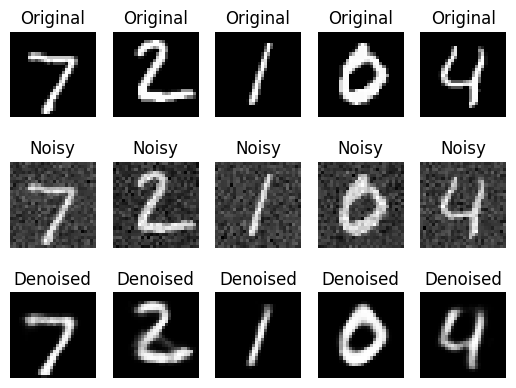

mlp_model Test Loss: 0.0002


KeyError: 'cnn_model'

In [24]:
for model_name in model_names:
    model = models[model_name]

    test_loss = 0.0

    model.eval()
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)
            outputs = model(noisy_img)

            loss = criterion(outputs, img)
            test_loss += loss.item()

            # Visualize the first 5 images
            for i in range(5):
                plt.subplot(3, 5, i + 1)
                plt.imshow(img[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Original")
                plt.axis("off")

                plt.subplot(3, 5, i + 6)
                plt.imshow(noisy_img[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Noisy")
                plt.axis("off")

                plt.subplot(3, 5, i + 11)
                plt.imshow(outputs[i].cpu().reshape(28, 28), cmap="gray")
                plt.title("Denoised")
                plt.axis("off")
            plt.show()
            break

        test_loss /= len(test_loader)   
        print(f"{model_name} Test Loss: {test_loss:.4f}")

Epoch [1/10], Loss: 0.0292
bn_model Validation Loss: 0.0078
Epoch [2/10], Loss: 0.0065
bn_model Validation Loss: 0.0053
Epoch [3/10], Loss: 0.0053
bn_model Validation Loss: 0.0047
Epoch [4/10], Loss: 0.0048
bn_model Validation Loss: 0.0044
Epoch [5/10], Loss: 0.0045
bn_model Validation Loss: 0.0040
Epoch [6/10], Loss: 0.0042
bn_model Validation Loss: 0.0039
Epoch [7/10], Loss: 0.0041
bn_model Validation Loss: 0.0038
Epoch [8/10], Loss: 0.0040
bn_model Validation Loss: 0.0036
Epoch [9/10], Loss: 0.0039
bn_model Validation Loss: 0.0041
Epoch [10/10], Loss: 0.0038
bn_model Validation Loss: 0.0036


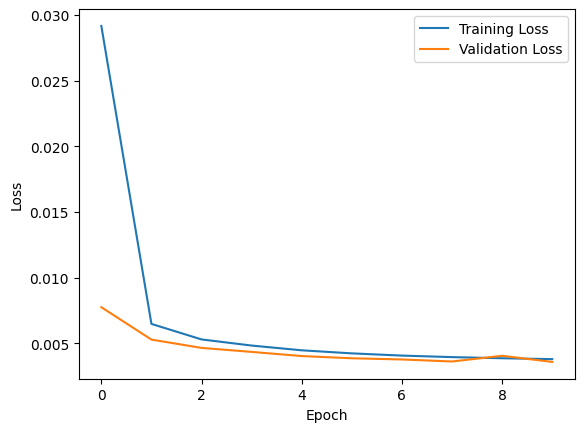

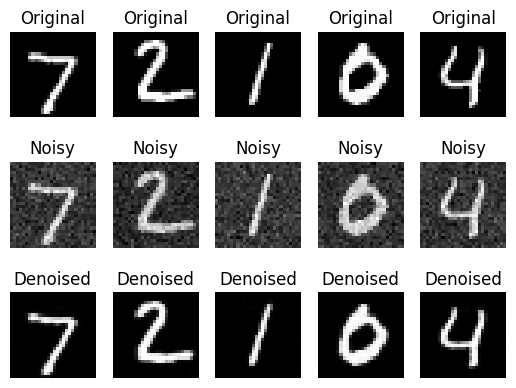

bn_model Test Loss: 0.0000


In [25]:
# # Conv-ConvTranspose Autoencoder FOR BATCH NORMALIZATION. Batch normalization is a technique that normalizes the
# inputs of each layer in a neural network by adjusting and scaling the activations. It helps in 
# Stabilizing training, faster convergance, and regularization effect.
class AutoencoderBN(nn.Module):
    def __init__(self):
        super(AutoencoderBN, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 8, kernel_size=3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(8),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(
                16, 32, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(
                32, 1, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.Tanh(),
        )

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)  # Reshape input to (Batch_size, Channels, Height, Width)
        x = self.encoder(x)
        x = self.decoder(x)
        return x.view(x.size(0), -1)  # Reshape back to (Batch_size, 784)


bn_model = AutoencoderBN().to(device)

# Use torchinfo summary to get model summary
summary(bn_model, input_size=(batch_size, 28 * 28), device=device)

optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)

epoch_losses = []
validation_losses = []

for epoch in range(num_epochs):
    bn_model.train()
    total_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        noisy_img = add_noise(img)
        # Forward pass
        outputs = bn_model(noisy_img)
        loss = criterion(outputs, img)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_epoch_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Calculate validation loss
    bn_model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            noisy_img = add_noise(img)
            outputs = bn_model(noisy_img)
            loss = criterion(outputs, img)
            validation_loss += loss.item()

    validation_loss /= len(test_loader)
    validation_losses.append(validation_loss)
    print(f"bn_model Validation Loss: {validation_loss:.4f}")

plt.figure()
plt.plot(epoch_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

test_loss = 0.0

bn_model.eval()
with torch.no_grad():
    for data in test_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        noisy_img = add_noise(img)
        outputs = bn_model(noisy_img)

        loss = criterion(outputs, img)
        test_loss += loss.item()

        # Visualize the first 5 images
        for i in range(5):
            plt.subplot(3, 5, i + 1)
            plt.imshow(img[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Original")
            plt.axis("off")

            plt.subplot(3, 5, i + 6)
            plt.imshow(noisy_img[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Noisy")
            plt.axis("off")

            plt.subplot(3, 5, i + 11)
            plt.imshow(outputs[i].cpu().reshape(28, 28), cmap="gray")
            plt.title("Denoised")
            plt.axis("off")
        plt.show()
        break

    test_loss /= len(test_loader)   
    print(f"bn_model Test Loss: {test_loss:.4f}")

- [ ] Try adapting your autoencoder to perform "in-painting":
  - Obscure sections of the image by zeroing out the values in a region of pixels
  - Train your autoencoder to reconstruct the obscured section


## Artifact and Metrics Logging


Reminder: document all your experiments by logging inputs (code, data, parameter values) and outputs (model predictions, performance metrics).


### 🚦 Checkpoint: Stop

- [ ] Uncomment this code
- [ ] Complete the feedback form
- [ ] Run the cell to log your responses and record your stop time:

In [ ]:
# deep_atlas.log_feedback(
#     {
#         # How long were you actively focused on this section? (HH:MM)
#         "active_time": FILL_THIS_IN,
#         # Did you feel finished with this section (Yes/No):
#         "finished": FILL_THIS_IN,
#         # How much did you enjoy this section? (1–5)
#         "enjoyment": FILL_THIS_IN,
#         # How useful was this section? (1–5)
#         "usefulness": FILL_THIS_IN,
#         # Did you skip any steps?
#         "skipped_steps": [FILL_THIS_IN],
#         # Any obvious opportunities for improvement?
#         "suggestions": [FILL_THIS_IN],
#     }
# )
# deep_atlas.log_stop_time()

## You did it!